<a href="https://colab.research.google.com/github/ruchira-shree/precision-med-crc/blob/main/TowardsPrecisionMedicine_CRC_DataAug_Trans_ResEffNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TOWARDS PRECISION MEDICINE : COLORECTAL CANCER


Setup

In [ ]:
# Setup Cell to import libraries and download data!

import random
from IPython.display import Markdown, display, clear_output

import tensorflow as tf

import numpy as np
np.random.seed(1)

import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

import os

import requests

download_url = "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Towards%20Precision%20Medicine/"

for file in ["images.npy"]:
    r = requests.get(download_url + file)
    with open(file, "wb") as f:
        f.write(r.content)
    images = np.load(file)

for file in ["labels.npy"]:
    r = requests.get(download_url + file)
    with open(file, "wb") as f:
        f.write(r.content)
    labels = np.load(file)


import os
os.remove("images.npy")
os.remove("labels.npy")


# Using the get_dummies() function to one-hot encode  labels.
labels_ohe = np.array(pd.get_dummies(labels))

# Select your feature (X) and labels (y).
y = labels_ohe
X = images / 255.

# Split your data into training and testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

# Define Function `probability_vector_to_predictions()
# dictionary that converts the one-hot encoded label indice into the label name
one_hot_encoding_to_label_dict = {np.argmax(ohe):label for ohe, label in zip(labels_ohe, labels)}

def probability_vector_to_predictions(prob_vector):
  class_num = np.argmax(prob_vector) # Find which element in the vector has the highest score.
  class_name = one_hot_encoding_to_label_dict[class_num] # Figure out the label that corresponds to this element.
  return class_name, max(prob_vector) # Return the label as well as the probabilty that the model assigned to this prediction.

# Define function to resize images
def ResizeImages(images, height, width):
  return np.array([tf.image.resize_with_pad(image, height, width, antialias=True) for image in images]).astype(int)

#Define function to plot metrics from the training epoch
def plot_metric(history, metric="accuracy", best_is_max=True, start_epoch=0, random_model_metric=None):
  # Get lists of accuracies over the epochs
  training_accuracy = history.history[metric][start_epoch:]
  validation_accuracy = history.history['val_' + metric][start_epoch:]

  # Find best epoch depending on whether max is the best for the metric
  if best_is_max:
    best_epoch = validation_accuracy.index(max(validation_accuracy))
  else:
    best_epoch = validation_accuracy.index(min(validation_accuracy))

  # Plot labels
  plt.title(metric.capitalize() + ' as Model Trains')
  plt.xlabel('Epoch #')
  plt.ylabel(metric.capitalize())

  # Plot lines
  plt.plot(training_accuracy, label='Train')
  plt.plot(validation_accuracy, label='Validation')
  plt.axvline(x=best_epoch, linestyle='--', color='green', label='Best Epoch')

  if random_model_metric is not None:
    plt.axhline(random_model_metric, linestyle='--',color='red', label='Chance')

  # Plot legend and show
  plt.legend()
  plt.show()


Review the Data. X_train is in the format (number_of_images, height, width, color_channels). y_train is in the format (number_of_images, number_of_classes). There are two dimensions because the labels are one-hot encoded, where each label is a vector with a 1 in the position of the true class and 0s everywhere else.

In [ ]:
# Print shapes of Training and Testing Data

print('shape of training images:', X_train.shape)
print('shape of training labels:', y_train.shape)
print('shape of testing images:', X_test.shape)
print('shape of testing labels:', y_test.shape)

NameError: name 'X_train' is not defined

In [ ]:
# Displaying first three images

for i in range(3):
  print(y_test[i])
  print(probability_vector_to_predictions(y_test[i]))

[False False False  True False False False False]
('empty', True)
[False  True False False False False False False]
('complex', True)
[False  True False False False False False False]
('complex', True)


Basic CNN model

In [ ]:
#construct the CNN model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Conv3D, Flatten, Dropout

# Select feature (X) and labels (y).
y = labels_ohe
X = images / 255.

# Split data into training and testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

# Initialize model
def construct_model():
  cnn = Sequential()

  # Input layer
  cnn.add(Input(shape=X_train.shape[1:]))

  # First layer
  # convolution to detect feature ( #features=out channels, kernel area to look at, activation function, padding)
  cnn.add(Conv2D(8, (3,3), activation='relu', padding="same"))
  # summarize to compress ( keeps strongest signal in 2x2 used in CNN)
  cnn.add(MaxPooling2D((2, 2)))

  # Second layer
  cnn.add(Conv2D(16, (3,3), activation='relu', padding="same"))
  cnn.add(MaxPooling2D((2, 2)))

  # Third layer
  cnn.add(Conv2D(32, (3,3), activation='relu', padding="same"))
  cnn.add(MaxPooling2D((2, 2)))

  # # Fourth layer
  cnn.add(Conv2D(64, (3,3), activation='relu', padding="same"))
  cnn.add(MaxPooling2D((2, 2)))

  # Flattening layer
  cnn.add(Flatten())

  # Hidden (dense) layer with 32 nodes, and relu activation function.
  cnn.add(Dense(32, activation='relu'))

  # Dropout layer with 50% dropout rate
  cnn.add(Dropout(0.15))

  # Final output layer that uses a softmax activation function.
  # the softmax layer outputs a vector of probabilities for each class.
  # The model's goal is to make its output probability vector as close as possible to the true one-hot encoded
  cnn.add(Dense(len(set(labels)), activation='softmax'))

  # Compile model
  metrics_to_track = ['categorical_crossentropy', 'accuracy']
  cnn.compile(loss='categorical_crossentropy',
                optimizer='rmsprop',
                metrics=metrics_to_track)
  return cnn

cnn = construct_model()

In [ ]:
#Baseline the CNN model
# # Get an image index from the test set. Using 8
sample_image = X_test[8]
true_label_index = np.argmax(y_test[8])

# The model expects a "batch" of images (i.e. multiple images at once), so we add an extra dimension
sample_image_expanded = np.expand_dims(sample_image, axis=0)

# Get the model's raw prediction. NOTE: The model is UNTRAINED, so this is a random guess.
prediction = cnn.predict(sample_image_expanded, verbose=0)

# Decoding the Untrained Model's Guess
print(f"The model's raw output for the image is a vector of {len(prediction[0])} numbers:\n")
print(prediction[0])

print("\nEven though the model is just guessing, the 'softmax' layer still forces the numbers to look like probabilities.")
print(f"They all add up to: {np.sum(prediction[0]):.2f}\n")

The model's raw output for the image is a vector of 8 numbers:

[0.11687113 0.12205223 0.12172983 0.13770099 0.12258276 0.12659773
 0.13145685 0.12100842]

Even though the model is just guessing, the 'softmax' layer still forces the numbers to look like probabilities.
They all add up to: 1.00



The highest value in the random vector is at index: 3
--> This corresponds to the random guess: 'empty'
--> The model's confidence in its random guess is: 13.77%

Notice that the prediction is likely incorrect and the confidence is low. This is what we expect from an untrained model!


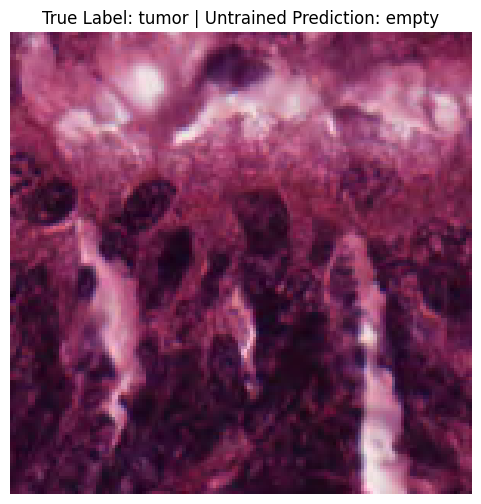

In [ ]:
# CNN Model's prediction and confidence
# Find the index of the highest probability in the random vector
predicted_index = np.argmax(prediction)
predicted_confidence = np.max(prediction)

# Define the class names in the correct order
class_names = sorted(pd.get_dummies(labels).columns)
true_label_name = class_names[true_label_index]

# Map the index to the class name
predicted_label_name = class_names[predicted_index]

print(f"The highest value in the random vector is at index: {predicted_index}")
print(f"--> This corresponds to the random guess: '{predicted_label_name}'")
print(f"--> The model's confidence in its random guess is: {predicted_confidence:.2%}\n")
print("Notice that the prediction is likely incorrect and the confidence is low. This is what we expect from an untrained model!")


# Visualize
plt.figure(figsize=(6, 6))
plt.imshow(sample_image)
plt.title(f"True Label: {true_label_name} | Untrained Prediction: {predicted_label_name}", fontsize=12)
plt.axis("off")
plt.show()

In [ ]:
# Model Parameters
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 8)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 37, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 18, 18, 32)        0

Epoch 1/20


12/12 [==============================] - 1s 60ms/step - loss: 2.0368 - categorical_crossentropy: 2.0368 - accuracy: 0.1758 - val_loss: 1.8955 - val_categorical_crossentropy: 1.8955 - val_accuracy: 0.1836
Epoch 2/20
12/12 [==============================] - 0s 42ms/step - loss: 1.7825 - categorical_crossentropy: 1.7825 - accuracy: 0.2721 - val_loss: 1.5673 - val_categorical_crossentropy: 1.5673 - val_accuracy: 0.3125
Epoch 3/20
12/12 [==============================] - 0s 39ms/step - loss: 1.6740 - categorical_crossentropy: 1.6740 - accuracy: 0.3125 - val_loss: 1.9383 - val_categorical_crossentropy: 1.9383 - val_accuracy: 0.1992
Epoch 4/20
12/12 [==============================] - 0s 39ms/step - loss: 1.6793 - categorical_crossentropy: 1.6793 - accuracy: 0.2956 - val_loss: 1.5202 - val_categorical_crossentropy: 1.5202 - val_accuracy: 0.3086
Epoch 5/20
12/12 [==============================] - 0s 39ms/step - loss: 1.6143 - categorical_crossentropy: 1.6143 - accuracy: 0.2904 - va

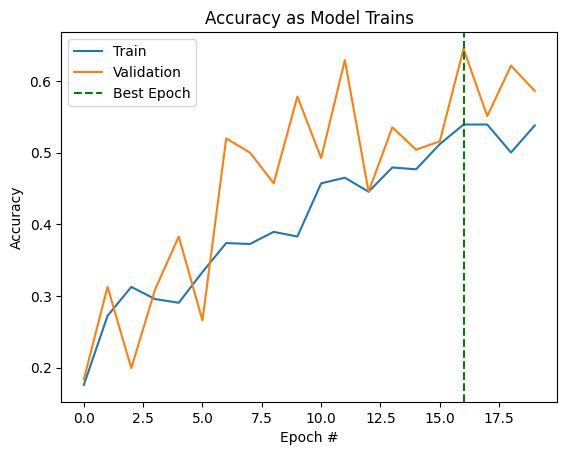


--- Model Loss ---


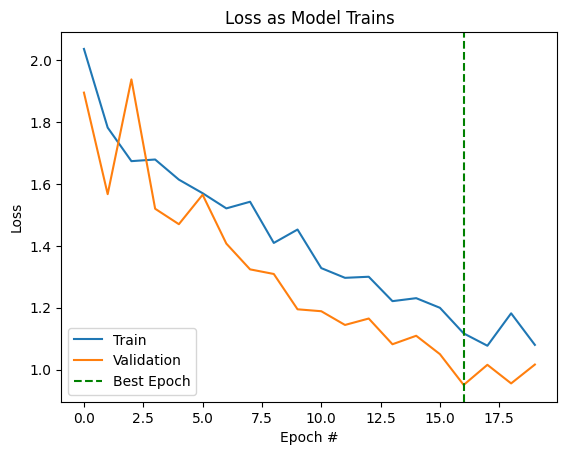

In [ ]:
# Training for 20 epochs with batch size 64 and checking loss/accuracy
history = cnn.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                        epochs=20)

# Plot the accuracy over time
print("\n--- Model Accuracy ---")
plot_metric(history, metric="accuracy")

# Plot the loss (error) over time
print("\n--- Model Loss ---")
plot_metric(history, metric="loss", best_is_max=False)

--- Decoding the Trained Model's Guess ---

The model's raw output for the image:

[0.00089615 0.13330911 0.02850243 0.0008076  0.3992666  0.12085279
 0.01280502 0.30356035] 

The highest value in the vector is at index: 4
--> This corresponds to the: 'lympho' label
--> The model's confidence in its prediction is: 39.93%

How did the trained model do?


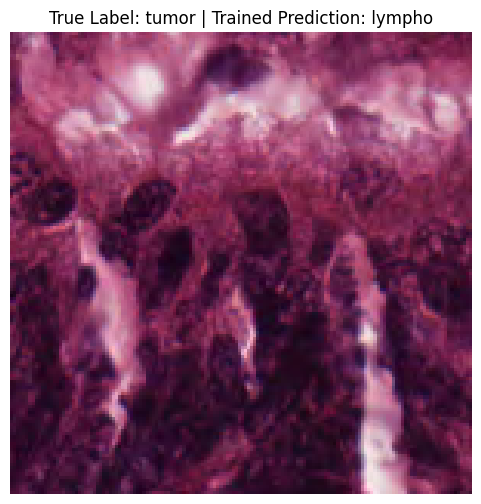

In [ ]:
# Let's predict on that same image again
sample_image = X_test[8]
true_label_index = np.argmax(y_test[8])

# View the trained model's outputs, prediction, and confidence
# The model expects a "batch" of images (i.e. multiple images at once), so we add an extra dimension
sample_image_expanded = np.expand_dims(sample_image, axis=0)

# Get the model's prediction.
prediction_vector = cnn.predict(sample_image_expanded, verbose=0)

print("--- Decoding the Trained Model's Guess ---\n")
print(f"The model's raw output for the image:\n")
print(prediction_vector[0],"\n")

# Find the index of the highest probability in the random vector
predicted_index = np.argmax(prediction_vector)
predicted_confidence = np.max(prediction_vector)

# Map the index to the class name
predicted_label_name = class_names[predicted_index]

print(f"The highest value in the vector is at index: {predicted_index}")
print(f"--> This corresponds to the: '{predicted_label_name}' label")
print(f"--> The model's confidence in its prediction is: {predicted_confidence:.2%}\n")
print("How did the trained model do?")

# --- Lets visualize it all ---
plt.figure(figsize=(6, 6))
plt.imshow(sample_image)
plt.title(f"True Label: {true_label_name} | Trained Prediction: {predicted_label_name}", fontsize=12)
plt.axis("off")
plt.show()

Data Augmentation: Four simple but effective ways to augment the images (vertical flip, horizontal flip, rotate, gamma correction)

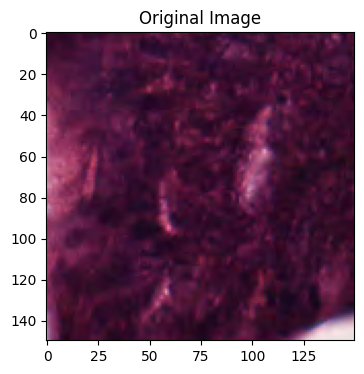

In [ ]:
##  Generate different image each time for Data Augmentation
from numpy import flipud, fliplr
from skimage.transform import rotate
from skimage.exposure import adjust_gamma

original_image = X_train[np.random.randint(len(X_train))]
plt.figure(figsize=(8, 4))
plt.imshow(original_image)
plt.title('Original Image')
plt.show()

--- 1. Vertical Flip ---


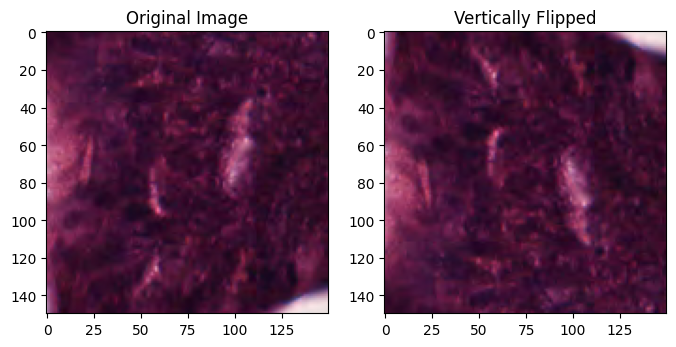

In [ ]:
# Flipping Upside Down (flipud)
augmented_ud = flipud(original_image)

f, ax = plt.subplots(ncols=2, figsize=(8, 4))
ax[0].imshow(original_image)
ax[0].set_title('Original Image')
ax[1].imshow(augmented_ud)
ax[1].set_title('Vertically Flipped')
plt.show()


--- 2. Horizontal Flip ---


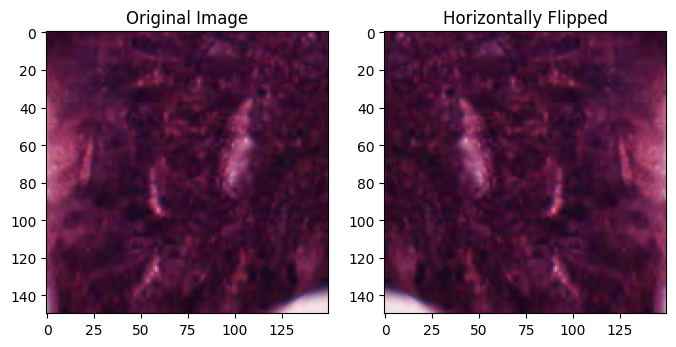

In [ ]:
# Flipping Left-to-Right (fliplr)
augmented_lr = fliplr(original_image)

f, ax = plt.subplots(ncols=2, figsize=(8, 4))
ax[0].imshow(original_image)
ax[0].set_title('Original Image')
ax[1].imshow(augmented_lr)
ax[1].set_title('Horizontally Flipped')
plt.show()


--- 3. Rotation ---


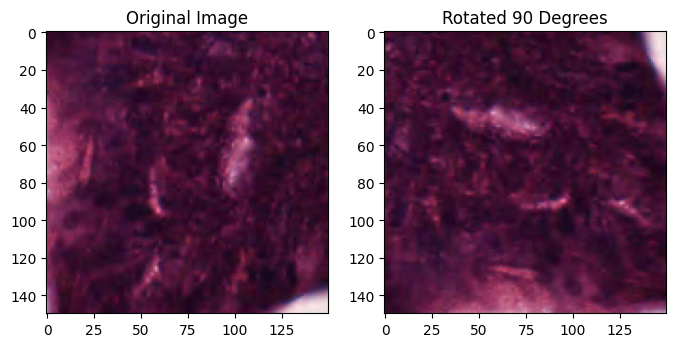

In [ ]:
# We rotate by 90 degrees. resize=False is important to keep the image dimensions the same.
augmented_rot = rotate(original_image, angle=90, resize=False)

f, ax = plt.subplots(ncols=2, figsize=(8, 4))
ax[0].imshow(original_image)
ax[0].set_title('Original Image')
ax[1].imshow(augmented_rot)
ax[1].set_title('Rotated 90 Degrees')
plt.show()


--- 4. Brightness Change ---


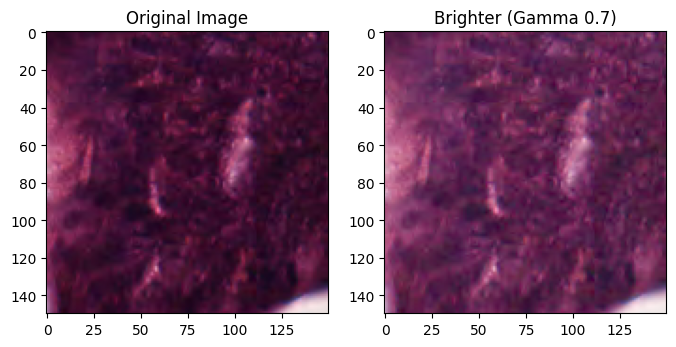

In [ ]:
# Gamma < 1 makes the image brighter. Gamma > 1 makes it darker.
augmented_bright = adjust_gamma(original_image, gamma=0.7)

f, ax = plt.subplots(ncols=2, figsize=(8, 4))
ax[0].imshow(original_image)
ax[0].set_title('Original Image')
ax[1].imshow(augmented_bright)
ax[1].set_title('Brighter (Gamma 0.7)')
plt.show()

In [ ]:
# Define DataAugmentation Function
# A function that randomly applies one of several augmentations
def create_random_augmented_image(original_image):

    # Randomly choose which augmentation to apply
    choice = random.randint(0, 3)

    if choice == 0:
        # Option 0: Flip upside down
        new_image = flipud(original_image)
    elif choice == 1:
        # Option 1: Flip left-to-right
        new_image = fliplr(original_image)
    elif choice == 2:
        # Option 2: Rotate 90 degrees
        new_image = rotate(original_image, angle=90, resize=False)
    else:
        # Option 3: Make it brighter
        new_image = adjust_gamma(original_image, gamma=0.7)

    return new_image

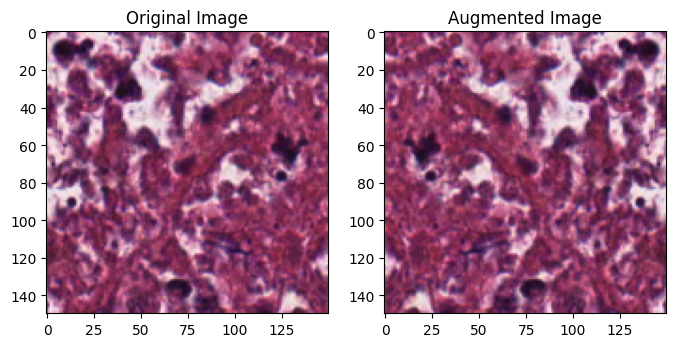

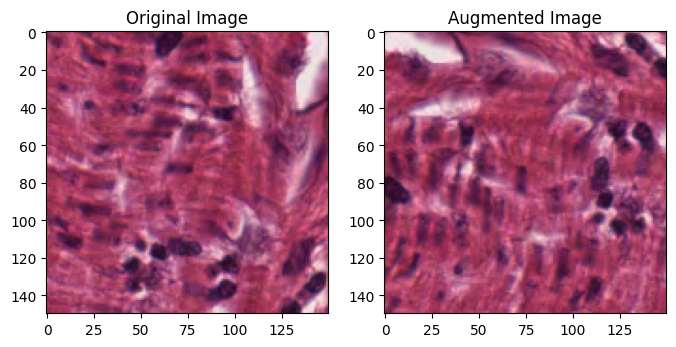

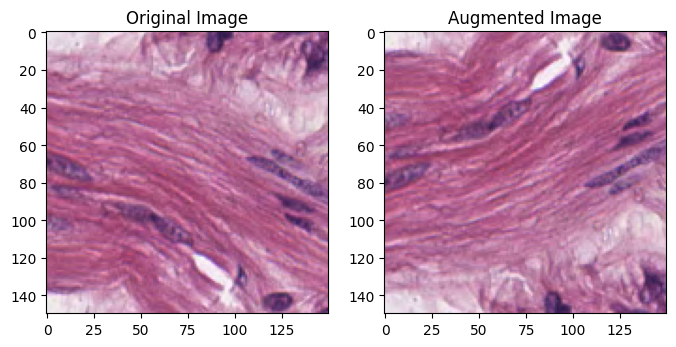

In [ ]:
# Testing out augmentation technique here to see if it works!
for image in X_train[:3]:
  f, ax = plt.subplots(ncols=2, figsize=(8, 4))
  ax[0].imshow(image)
  ax[0].set_title('Original Image')
  augmented_image = create_random_augmented_image(image)
  ax[1].imshow(augmented_image)
  ax[1].set_title('Augmented Image')
  plt.show()

In [ ]:
# Data Augmentation
# --- Create two empty lists to hold the new data ---
X_train_augment_list = []
y_train_augment_list = []

# --- Loop through the images to create an augmented dataset ---
for i in range(len(X_train)):
    # Get the original image and its label
    original_image = X_train[i]
    original_label = y_train[i]

    # Create a new, randomly augmented version of the image
    new_augmented_image = create_random_augmented_image(original_image)

    # Append the new image and its original label to the lists
    X_train_augment_list.append(new_augmented_image)
    y_train_augment_list.append(original_label)

# --- Convert the lists to NumPy arrays ---
X_train_augment = np.array(X_train_augment_list)
y_train_augment = np.array(y_train_augment_list)

X_train_combined = np.concatenate((X_train, X_train_augment), axis=0)
y_train_combined = np.concatenate((y_train, y_train_augment), axis=0)

# --- Verify the new shapes ---
print("Dimensions of original X_train:", X_train.shape)
print("Dimensions of augmented X:", X_train_augment.shape)
print("Dimensions of combined X_train:", X_train_combined.shape)
print("Shape of combined y_train:", y_train_combined.shape)

Dimensions of original X_train: (768, 150, 150, 3)
Dimensions of augmented X: (768, 150, 150, 3)
Dimensions of combined X_train: (1536, 150, 150, 3)
Shape of combined y_train: (1536, 8)


In [ ]:
# Resizing Images
X_train_unnormed = X_train_combined * 255.0
X_test_unnormed = X_test * 255.0
y_train_resized = y_train_combined
y_train_resized_eff = y_train_combined

# Resize image for transfer_cnn_resnet
X_train_resized = ResizeImages(X_train_unnormed, 224, 224)
X_test_resized = ResizeImages(X_test_unnormed, 224, 224)

# Resize image  for transfer_cnn_effnetb3
X_train_resized_eff = ResizeImages(X_train_unnormed, 300, 300)
X_test_resized_eff = ResizeImages(X_test_unnormed, 300, 300)

# Make sure images are the right dimensions
print("Dim X_train_resized:", X_train_resized.shape)
print("Dim X_test_resized:", X_test_resized.shape)

Dim X_train_resized: (1536, 224, 224, 3)
Dim X_test_resized: (256, 224, 224, 3)


Epoch 1/20
48/48 [==============================] - 2s 24ms/step - loss: 1.9085 - categorical_crossentropy: 1.9085 - accuracy: 0.2083 - val_loss: 1.5651 - val_categorical_crossentropy: 1.5651 - val_accuracy: 0.3281
Epoch 2/20
48/48 [==============================] - 1s 19ms/step - loss: 1.6346 - categorical_crossentropy: 1.6346 - accuracy: 0.3249 - val_loss: 1.3737 - val_categorical_crossentropy: 1.3737 - val_accuracy: 0.3906
Epoch 3/20
48/48 [==============================] - 1s 16ms/step - loss: 1.4320 - categorical_crossentropy: 1.4320 - accuracy: 0.3867 - val_loss: 1.4712 - val_categorical_crossentropy: 1.4712 - val_accuracy: 0.3750
Epoch 4/20
48/48 [==============================] - 1s 16ms/step - loss: 1.3145 - categorical_crossentropy: 1.3145 - accuracy: 0.4427 - val_loss: 0.9855 - val_categorical_crossentropy: 0.9855 - val_accuracy: 0.6289
Epoch 5/20
48/48 [==============================] - 1s 16ms/step - loss: 1.2402 - categorical_crossentropy: 1.2402 - accuracy: 0.4505 - val_

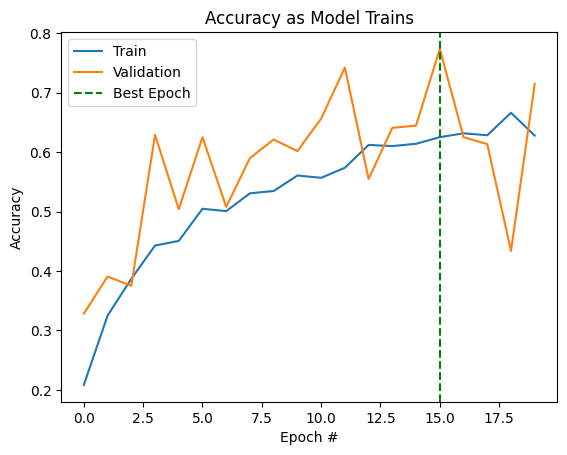

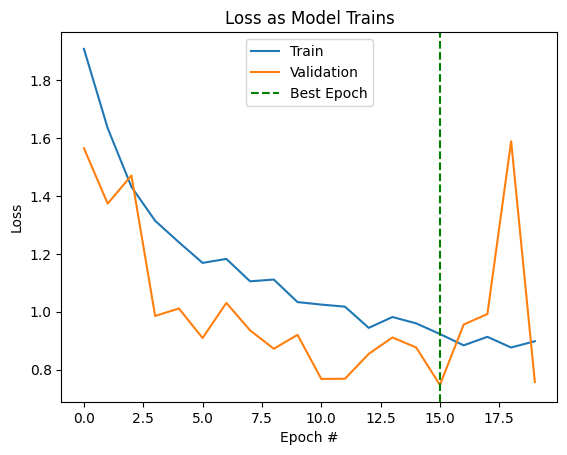

In [ ]:
# Retraining for 20 epochs with augmented dataset, default batch size 32
cnn = construct_model()
additional_history = cnn.fit(X_train_combined, y_train_combined,
                             validation_data=(X_test, y_test),
                             epochs=20)
plot_metric(additional_history) # Example of Accuracy
plot_metric(additional_history, metric="loss", best_is_max=False) # Example of loss

TRANSFER LEARNING STARTING WITH RESNET50 : Looking at Input Layer its H=224, W=224, Channels=3, batchsize=None. Outputlayer shows 1000 classification labels.

In [ ]:
# import pretrained ResNet
from tensorflow.keras.applications import ResNet50
res_net = ResNet50(include_top=True)
res_net.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [ ]:
# customizing Transfer Model with Func API
from tensorflow.keras import Model

# Get ResNet's output from the layer before the last Dense layer, and add on a
# custom Dense layer and Dropout layer
output_from_resnet = res_net.layers[-2].output
x = Dense(128, activation='relu')(output_from_resnet)
x = Dropout(0.50)(x) # Add 50% dropout

new_output_layer = Dense(len(y_train[0]), activation='softmax')(x)

# The next couple lines are necessary to build the complete network using the
# majority of the ResNet50 network as well as the custom layers from above.
input = res_net.input
transfer_cnn = Model(input, new_output_layer)

# print the summary
transfer_cnn.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [ ]:
# Freeze weights for all layers except last three and compile
# make all layers untrainable by freezing weights (except for last layer)
for layer in transfer_cnn.layers:
    layer.trainable = False

## Set the final three layer as trainable=True
for layer in transfer_cnn.layers[-3:]:
    layer.trainable = True

# Compile new model using loss='categorical_crossentropy'
# optimizer='adam' and metrics=['accuracy', 'categorical_crossentropy']
transfer_cnn.compile(loss='categorical_crossentropy',
                     optimizer='adam',
                     metrics=['accuracy', 'categorical_crossentropy'])

# Look at the summary of the network to make sure the structure is as you expect!
transfer_cnn.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

Epoch 1/20
48/48 [==============================] - 37s 734ms/step - loss: 1.0713 - accuracy: 0.6660 - categorical_crossentropy: 1.0713 - val_loss: 0.5100 - val_accuracy: 0.8125 - val_categorical_crossentropy: 0.5100
Epoch 2/20
48/48 [==============================] - 34s 720ms/step - loss: 0.5161 - accuracy: 0.8171 - categorical_crossentropy: 0.5161 - val_loss: 0.3880 - val_accuracy: 0.8789 - val_categorical_crossentropy: 0.3880
Epoch 3/20
48/48 [==============================] - 34s 715ms/step - loss: 0.3907 - accuracy: 0.8646 - categorical_crossentropy: 0.3907 - val_loss: 0.3670 - val_accuracy: 0.8711 - val_categorical_crossentropy: 0.3670
Epoch 4/20
48/48 [==============================] - 36s 748ms/step - loss: 0.3195 - accuracy: 0.8945 - categorical_crossentropy: 0.3195 - val_loss: 0.3496 - val_accuracy: 0.8945 - val_categorical_crossentropy: 0.3496
Epoch 5/20
48/48 [==============================] - 34s 712ms/step - loss: 0.2933 - accuracy: 0.9134 - categorical_crossentropy: 0.2

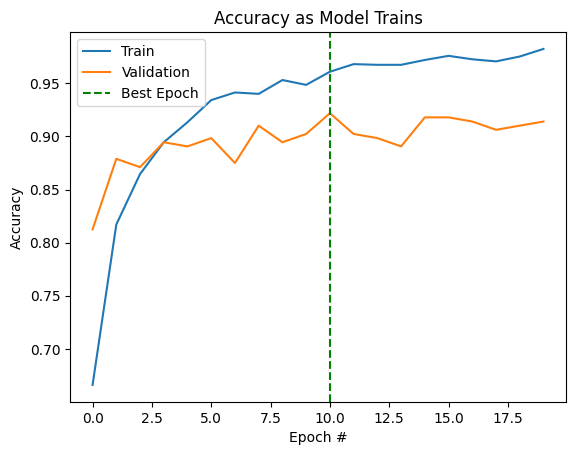

In [ ]:
# Finetune model with augmented data
transfer_history = transfer_cnn.fit(X_train_resized, y_train_resized,
                                    validation_data=(X_test_resized, y_test),
                                    epochs=20)
plot_metric(transfer_history)

8/8 [==============================] - 6s 656ms/step
              precision    recall  f1-score   support

     adipose       0.98      1.00      0.99        43
     complex       0.82      0.79      0.81        29
      debris       0.91      0.87      0.89        23
       empty       1.00      0.97      0.99        39
      lympho       0.86      0.90      0.88        20
      mucosa       0.81      0.97      0.88        31
      stroma       0.91      0.88      0.90        34
       tumor       0.97      0.86      0.91        37

    accuracy                           0.91       256
   macro avg       0.91      0.91      0.91       256
weighted avg       0.92      0.91      0.91       256



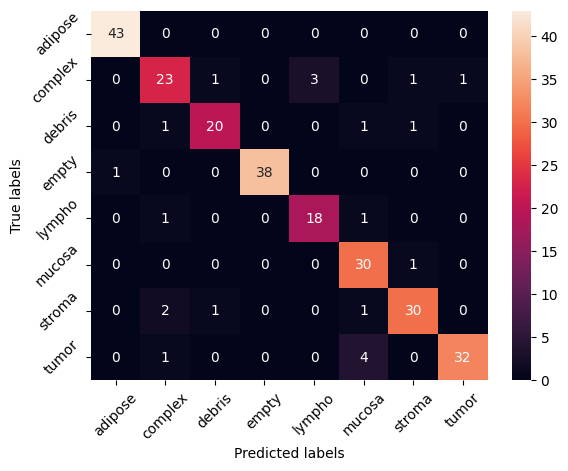

In [ ]:
#To obtain Confusion Matrix and Classification Report
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
logits = transfer_cnn.predict(X_test_resized)
vals = np.argmax(logits, axis=1)
y_pred = np.array([one_hot_encoding_to_label_dict[val] for val in vals])
y_true = np.array([one_hot_encoding_to_label_dict[y_val] for y_val in np.argmax(y_test, axis=1)])

sns.heatmap(pd.crosstab(y_true, y_pred), annot=True)
print(classification_report(y_true, y_pred))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

TRANSFER MODEL STARTING WITH EfficientNetB3

In [ ]:
# import EfficientNetB3

from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB3

NUM_CLASSES = len(y_train[0])
IMG_SIZE = (300, 300, 3)

def squeeze_excite_block(inputs, ratio=16):
    channels = inputs.shape[-1]
    se = layers.GlobalAveragePooling2D()(inputs)
    se = layers.Dense(channels // ratio, activation="relu")(se)
    se = layers.Dense(channels, activation="sigmoid")(se)
    se = layers.Reshape((1, 1, channels))(se)
    return layers.Multiply()([inputs, se])

# Base pretrained model
base_model = EfficientNetB3(
    weights="imagenet",
    include_top=False,
    input_shape=IMG_SIZE
)

# Freeze backbone initially
base_model.trainable = False
inputs = layers.Input(shape=IMG_SIZE)
x = base_model(inputs, training=False)

# Channel attention
x = squeeze_excite_block(x)

# Classification head
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

transfer_enb_model = models.Model(inputs, outputs)

fransfer_enb_model.compile( loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=["accuracy", "categorical_crossentropy"]
)

transfer_enb_model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 300, 300, 3)]        0         []                            
                                                                                                  
 efficientnetb3 (Functional  (None, 10, 10, 1536)         1078353   ['input_5[0][0]']             
 )                                                        5                                       
                                                                                                  
 global_average_pooling2d (  (None, 1536)                 0         ['efficientnetb3[0][0]']      
 GlobalAveragePooling2D)                                                                          
                                                                                            

Epoch 1/20
48/48 [==============================] - 56s 1s/step - loss: 0.8234 - accuracy: 0.7448 - categorical_crossentropy: 0.8234 - val_loss: 0.4040 - val_accuracy: 0.8711 - val_categorical_crossentropy: 0.4040
Epoch 2/20
48/48 [==============================] - 50s 1s/step - loss: 0.3152 - accuracy: 0.8997 - categorical_crossentropy: 0.3152 - val_loss: 0.3529 - val_accuracy: 0.8789 - val_categorical_crossentropy: 0.3529
Epoch 3/20
48/48 [==============================] - 50s 1s/step - loss: 0.2132 - accuracy: 0.9329 - categorical_crossentropy: 0.2132 - val_loss: 0.3585 - val_accuracy: 0.8711 - val_categorical_crossentropy: 0.3585
Epoch 4/20
48/48 [==============================] - 52s 1s/step - loss: 0.1606 - accuracy: 0.9512 - categorical_crossentropy: 0.1606 - val_loss: 0.3317 - val_accuracy: 0.8906 - val_categorical_crossentropy: 0.3317
Epoch 5/20
48/48 [==============================] - 50s 1s/step - loss: 0.1115 - accuracy: 0.9740 - categorical_crossentropy: 0.1115 - val_loss:

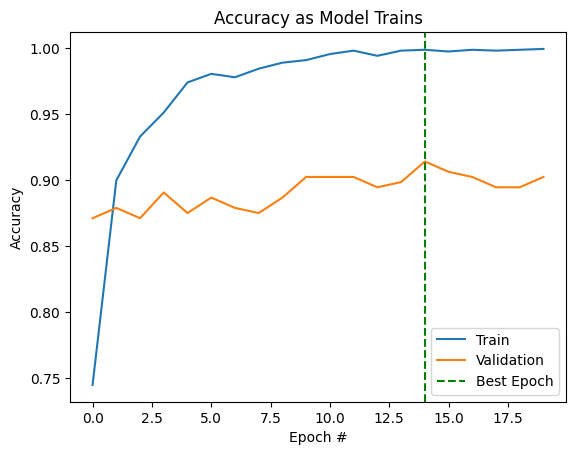

In [ ]:
## Initial Training with augmented data resized for 300
enb_history = transfer_enb_model.fit(X_train_resized_eff, y_train_resized_eff,
                         validation_data=(X_test_resized_eff, y_test),
                         epochs=20)

plot_metric(enb_history)


In [ ]:
##Fine-Tuning Strategy (Critical for Accuracy)
##After initial convergence: Unfreeze output layers of EfficientNetB3
for layer in base_model.layers[-40:]:
    layer.trainable = True

transfer_enb_model.compile(
        loss="categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        metrics=["accuracy", "categorical_crossentropy"]
)

transfer_enb_model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 300, 300, 3)]        0         []                            
                                                                                                  
 efficientnetb3 (Functional  (None, 10, 10, 1536)         1078353   ['input_5[0][0]']             
 )                                                        5                                       
                                                                                                  
 global_average_pooling2d (  (None, 1536)                 0         ['efficientnetb3[0][0]']      
 GlobalAveragePooling2D)                                                                          
                                                                                            

Epoch 1/20
48/48 [==============================] - 58s 1s/step - loss: 0.0038 - accuracy: 1.0000 - categorical_crossentropy: 0.0038 - val_loss: 0.4165 - val_accuracy: 0.9062 - val_categorical_crossentropy: 0.4165
Epoch 2/20
48/48 [==============================] - 50s 1s/step - loss: 0.0032 - accuracy: 1.0000 - categorical_crossentropy: 0.0032 - val_loss: 0.4185 - val_accuracy: 0.9062 - val_categorical_crossentropy: 0.4185
Epoch 3/20
48/48 [==============================] - 50s 1s/step - loss: 0.0036 - accuracy: 1.0000 - categorical_crossentropy: 0.0036 - val_loss: 0.4167 - val_accuracy: 0.9141 - val_categorical_crossentropy: 0.4167
Epoch 4/20
48/48 [==============================] - 49s 1s/step - loss: 0.0029 - accuracy: 1.0000 - categorical_crossentropy: 0.0029 - val_loss: 0.4178 - val_accuracy: 0.9141 - val_categorical_crossentropy: 0.4178
Epoch 5/20
48/48 [==============================] - 49s 1s/step - loss: 0.0027 - accuracy: 1.0000 - categorical_crossentropy: 0.0027 - val_loss:

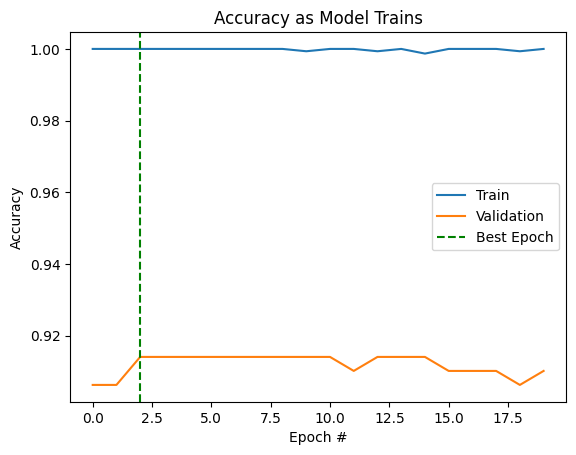

In [ ]:
#Train last few layers of EfficientNetB3 model
transfer_enb_history = transfer_enb_model.fit(X_train_resized_eff, y_train_resized_eff ,
                                              validation_data=(X_test_resized_eff, y_test),
                                              epochs=20)
plot_metric(transfer_enb_history)

8/8 [==============================] - 8s 925ms/step
              precision    recall  f1-score   support

     adipose       1.00      1.00      1.00        43
     complex       0.84      0.72      0.78        29
      debris       0.92      1.00      0.96        23
       empty       1.00      0.97      0.99        39
      lympho       0.68      0.85      0.76        20
      mucosa       0.93      0.84      0.88        31
      stroma       0.91      0.91      0.91        34
       tumor       0.89      0.92      0.91        37

    accuracy                           0.91       256
   macro avg       0.90      0.90      0.90       256
weighted avg       0.91      0.91      0.91       256



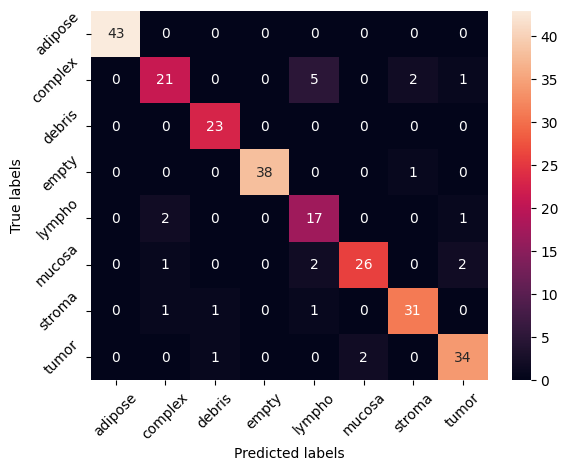

In [ ]:
#To obtain Confusion Matrix and Classification Report
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
logits = transfer_enb_model.predict(X_test_resized_eff)
vals = np.argmax(logits, axis=1)
y_pred = np.array([one_hot_encoding_to_label_dict[val] for val in vals])
y_true = np.array([one_hot_encoding_to_label_dict[y_val] for y_val in np.argmax(y_test, axis=1)])

sns.heatmap(pd.crosstab(y_true, y_pred), annot=True)
print(classification_report(y_true, y_pred))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()